# 03_Multi_classification

## title

- 3.1 The Reuters dataset
- 3.2 Preparing the data
- 3.3 Building your network
- 3.4 Generating predictions on new data
- 3.5 The importance of having sufficiently large intermediate layers

로이터(Reuter) 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망을 만들겠습니다. 클래스가 많기 때문에 이 문제는 다중 분류의 예입니다. 각 데이터 포인트가 정확히 하나의 범주로 분류되기 때문에 좀 더 정확히 말하면 단일 레이블 다중 분류문제입니다. 각 데이터 포인트가 여러 개의 범주에 속할 수 있다면 이 것은 다중 레이블 다중 분류 문제가 됩니다.

## Setup

In [1]:
%run setup.py

<br>

## 3.1 The Reuters dataset

1996년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터셋을 사용하겠습니다(원본 로이터셋의 135개 토픽 중에서 샘플이 많은 것을 뽑아 간단하게 만든 것입니다). 이 데이터셋은 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋입니다. 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많습니다. 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있습니다.

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

num_words = 10000 매개변수는 데이터에서 가장 자주 등장하는 단어 1만개로 제한합니다. 



In [3]:
print("train_data의 길이: {}".format(len(train_data)))
print("test_data의 길이: {}".format(len(test_data)))

train_data의 길이: 8982
test_data의 길이: 2246


<br>
각 샘플은 정수 리스트입니다.

In [4]:
np.array(train_data[10])

array([   1,  245,  273,  207,  156,   53,   74,  160,   26,   14,   46,
        296,   26,   39,   74, 2979, 3554,   14,   46, 4689, 4329,   86,
         61, 3499, 4795,   14,   61,  451, 4329,   17,   12])

<br>
디코딩은 다음과 같이 진행합니다.

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[0]]
)
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

<br>
샘플에 연결된 레이블은 토픽의 인덱스로 0과 45 사이의 정수입니다.

In [6]:
mins = min(train_labels)
maxes = max(train_labels)

print("레이블의 범위: {} ~ {}".format(mins, maxes))

레이블의 범위: 0 ~ 45


<br>

## 3.2 Preparing the data

데이터를 one-hot encoding으로 변환합니다.

In [7]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros([len(sequences), dimension])
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

train_data_scaled = vectorize_sequences(train_data)
test_data_scaled = vectorize_sequences(test_data)

<br>
훈련데이터세트를 검증데이터와 훈련데이터로 나눕니다.

In [8]:
X_valid, X_train = train_data_scaled[:1000], train_data_scaled[1000:]
X_test = test_data_scaled

<br>
레이블을 벡터로 바꾸는 방법은 2가지 입니다. 레이블의 리스트를 정수 텐서로 변환하는 것과 원-핫 인코딩을 사용하는 것입니다. 원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩(categorical encoding)이라고도 부릅니다. 각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터입니다. 

> 원-핫 인코딩 함수 직접 만들기

In [9]:
# 레이블이 45까지 있으므로 "45"인 인덱스가 필요합니다. 파이썬에서는 0부터 시작하므로 46까지의 dimension이 있어야 45를 표현할 수 있습니다.
def to_one_hot(labels, dimension=46):
    results = np.zeros([len(labels), dimension])
    
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [10]:
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

<br>

> keras API 이용

In [11]:
from tensorflow.keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels, dtype="int")
one_hot_test_labels = to_categorical(test_labels, dtype="int")

<br>
레이블또한 검증데이터와 훈련데이터로 나눕니다.

In [12]:
y_valid, y_train = train_labels[:1000], train_labels[1000:]

<br>

## 3.3 Building your network

이 토픽 분류 문제는 이전의 영화 리뷰 문제와 비슷해 보입니다. 두 경우 모두 짧은 텍스트를 분류하는 것이죠. 여기에서는 새로운 제약 사항이 추가되었습니다. 출력 클래스의 갯수가 2개에서 46개로 늘어난 점입니다.  

이전에 사용했던 것처럼 Dense층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있습니다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없습니다. 각 층은 잠재적으로 정보의 병목(information bottlenect)이 될 수 있습니다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많습니다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있습니다.  

따라서 64개의 유닛을 사용하겠습니다.

In [13]:
clear_session()
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000, )))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

W0811 07:59:16.279741 140151404832576 deprecation.py:506] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<br>

**이 구조에서 주목해야 할 점이 2가지가 있습니다.**  

- 마지막 Dense층의 크기가 46입니다. 각 입력 샘플에 대해서 46차원(45개 레이블)의 벡터를 출력한다는 뜻입니다. 이 벡터의 각 원소는 각기 다른 출력 클래스가 인코딩 된 것입니다.  

- 마지막 층에 softmax 활성화 함수가 사용되었습니다. 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력합니다. 즉 46차원의 출력 벡터를 만들며 output[i]는 어떤 샘플이 클래스 i에 속할 확률입니다. 46개의 값을 모두 더하면 1이 됩니다.  

이런 문제에 사용할 최선의 손실 함수는 ***categorical_crossentropy***입니다. 이 함수는 두 확률 분포 사이의 거리를 측정합니다. 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리입니다. 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훌련하게 됩니다.

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy

In [15]:
model.compile(optimizer=Adam(), 
              loss=sparse_categorical_crossentropy, 
              metrics=[sparse_categorical_accuracy])

<br>

이제 30번의 에포크로 모델을 훈련시킵니다.

In [16]:
epochs=30
class_mode = "sparse_categorical_accuracy"

In [17]:
%%time
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=512,
                    verbose=0,
                    validation_data=(X_valid, y_valid),
                    callbacks=[LossAndError(epochs=epochs, class_mode=class_mode, validation=True)])

Epoch 1/30, loss: 2.51315, sparse_categorical_accuracy: 0.44074
history key: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']
Epoch 6/30, loss: 0.65035, sparse_categorical_accuracy: 0.85793, val_loss: 0.97929, val_sparse_categorical_accuracy: 0.78900
Epoch 12/30, loss: 0.19124, sparse_categorical_accuracy: 0.95365, val_loss: 0.95172, val_sparse_categorical_accuracy: 0.81200
Epoch 18/30, loss: 0.10938, sparse_categorical_accuracy: 0.96029, val_loss: 1.02968, val_sparse_categorical_accuracy: 0.80300
Epoch 24/30, loss: 0.09050, sparse_categorical_accuracy: 0.96329, val_loss: 1.04416, val_sparse_categorical_accuracy: 0.80800
Epoch 30/30, loss: 0.08238, sparse_categorical_accuracy: 0.96267, val_loss: 1.10904, val_sparse_categorical_accuracy: 0.80200
CPU times: user 1min 39s, sys: 55.4 s, total: 2min 35s
Wall time: 5min 22s


<br>

마지막으로 손실과 정확도 곡선을 그립니다.

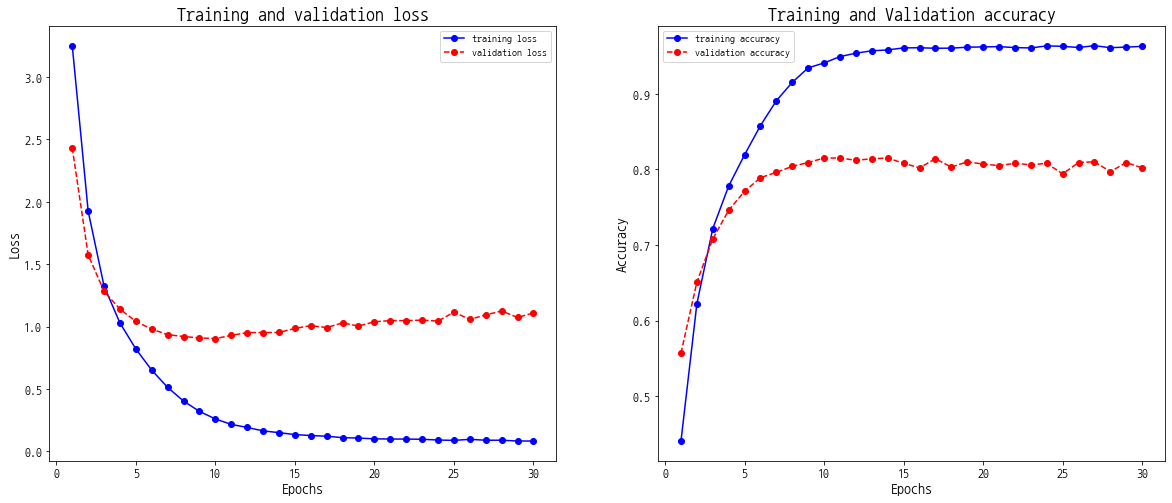

In [18]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

이 모델은 9번째 에포크 이후에 과대적합이 시작됩니다. 9번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가하겠습니다.

In [19]:
clear_session()
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000, )))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(optimizer=Adam(), 
              loss=sparse_categorical_crossentropy, 
              metrics=[sparse_categorical_accuracy])

In [20]:
epochs = 9
class_mode = "sparse_categorical_accuracy"
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=512,
                    verbose=0,
                    callbacks=[LossAndError(epochs=epochs, class_mode=class_mode, validation=False)])

Epoch 1/9, loss: 2.56790, sparse_categorical_accuracy: 0.49599
history key: ['loss', 'sparse_categorical_accuracy']
Epoch 2/9, loss: 1.92928, sparse_categorical_accuracy: 0.63192
Epoch 4/9, loss: 0.96197, sparse_categorical_accuracy: 0.79316
Epoch 6/9, loss: 0.57869, sparse_categorical_accuracy: 0.88136
Epoch 8/9, loss: 0.35984, sparse_categorical_accuracy: 0.92120
Epoch 9/9, loss: 0.28986, sparse_categorical_accuracy: 0.93548


<br>

마지막으로 손실과 정확도 곡선을 그립니다.

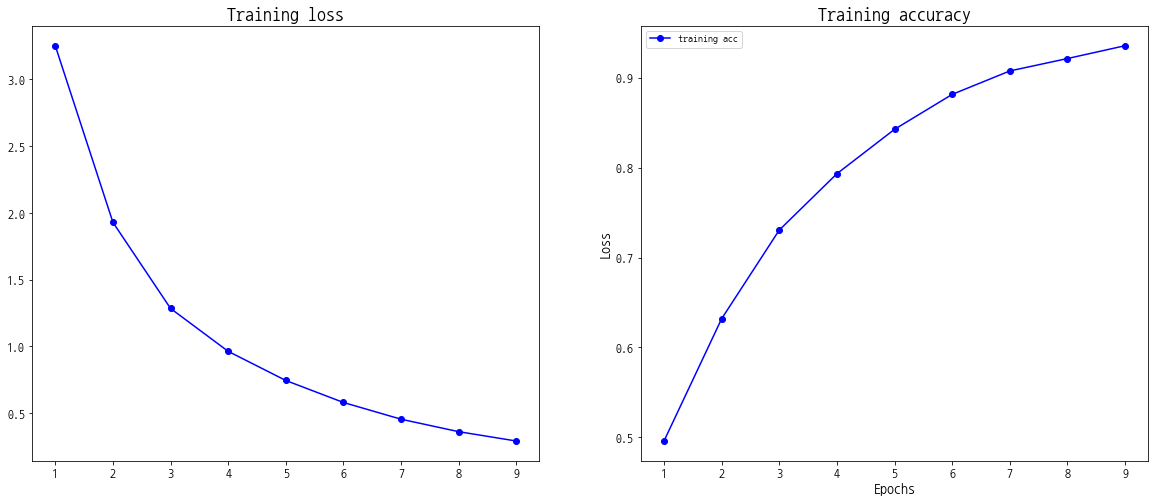

In [21]:
loss_and_acc_plot(history, class_mode=class_mode, validation=False)

In [22]:
import numpy as np

In [23]:
# sparse_categorical_accuracy의 레이블은 원핫인코딩을 원래 값으로 돌려야 합니다.
results = model.evaluate(X_test, np.argmax(one_hot_test_labels, axis=1))

2246/2246 [==============================] - 4s 2ms/sample - loss: 0.9485 - sparse_categorical_accuracy: 0.7885 0s - loss: 0.9443 - sparse_categorical_accuracy: 0.788


대략 78%의 정확도를 달성했습니다. 균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성합니다. 이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 18% 정도를 달성합니다. 여기에 비하면 이 결과는 괘 좋은 편입니다.

In [24]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)

float(np.sum(hits_array)) / len(test_labels)

0.18699910952804988

<br>

## 3.4 Generating predictions on new data

모델 객체의 predict 메서드는 46개의 토픽에 대한 확률 분포를 반환합니다. 테스트 데이터 전체에 대한 토픽을 예측해보겠습니다.

In [25]:
predictions = model.predict(X_test)

In [26]:
predictions[0].shape

(46,)

<br>

이 벡터의 원소 합은 1입니다.

In [27]:
np.sum(predictions[0])

1.0000001

<br>

가장 큰 값이 예측 클래스가 됩니다. 즉 가장 확률이 높은 클래스입니다.

In [28]:
np.argmax(predictions[0])

3

<br> 

## 3.5 The importance of having sufficiently large intermediate layers

마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안됩니다. 46차원보다 훨씬 작은 중간층(예를 들어 4차원) 두면 정보의 병목이 어떻게 나타나는지 확인해 보겠습니다.

In [29]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics

def my_models(hidden):
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(10000, )))
    model.add(layers.Dense(hidden, activation="relu"))
    model.add(layers.Dense(46, activation="softmax"))
    
    model.compile(optimizer=optimizers.Adam(), 
                  loss=losses.sparse_categorical_crossentropy, 
                  metrics=[metrics.sparse_categorical_accuracy])
    
    history = model.fit(X_train, y_train, 
                    epochs=9, 
                    batch_size=512,
                    verbose=0,
                    validation_data=(X_valid, y_valid),
                    callbacks=None)
    
    return model, history

> hidden layer가 4일 때

In [30]:
model_hidden4, history_hidden4 = my_models(hidden=4)

model_hidden4.evaluate(X_test, np.argmax(one_hot_test_labels, axis=1))

2246/2246 [==============================] - 3s 1ms/sample - loss: 1.6233 - sparse_categorical_accuracy: 0.6024


[1.623299618013608, 0.6024043]

<br>

> hidden layer가 128일 때

In [31]:
model_hidden128, history_hidden128 = my_models(hidden=128)

model_hidden128.evaluate(X_test, np.argmax(one_hot_test_labels, axis=1))

2246/2246 [==============================] - 2s 938us/sample - loss: 0.9558 - sparse_categorical_accuracy: 0.7930


[0.9557894641336117, 0.7929653]

<br>

위의 결과를 시각화 해보겠습니다.

In [32]:
import matplotlib.pyplot as plt

In [33]:
history_dict_4 = history_hidden4.history
history_dict_128 = history_hidden128.history

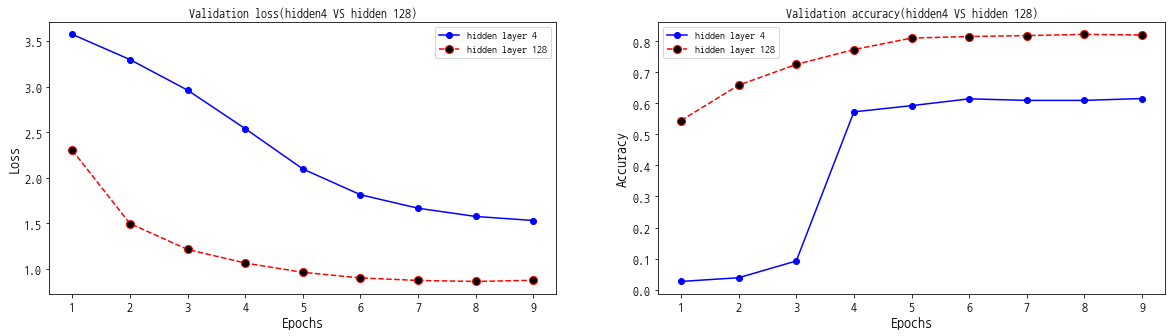

In [34]:
# ['loss', 'sparse_categorical_accuracy']
loss_4 = history_dict_4["val_loss"]
loss_128 = history_dict_128["val_loss"]

acc_4 = history_dict_4["val_sparse_categorical_accuracy"]
acc_128 = history_dict_128["val_sparse_categorical_accuracy"]

epochs = range(1, len(loss_4)+1)

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(epochs, loss_4, "bo-", label="hidden layer 4")
plt.plot(epochs, loss_128, "ro--", label="hidden layer 128", 
         marker="o", markersize=8, markerfacecolor="k")
plt.title("Validation loss(hidden4 VS hidden 128)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_4, "bo-", label="hidden layer 4")
plt.plot(epochs, acc_128, "ro--", label="hidden layer 128", 
         marker="o", markersize=8, markerfacecolor="k")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation accuracy(hidden4 VS hidden 128)")
plt.legend()

plt.show()

검증 정확도의 값이 대부분 hidden layer가 많을 때가 높습니다. 이런 손실의 원인 대부분은 많은 정보(클래스 46개의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문입니다. 이 네트워크는 필요한 정보 대부분을 4차원에 압축해서 넣었지만 전부 넣지는 못하여 위 그림처럼 나오게 됩니다.